# Campagne de financement participatif de 2014 à 2025

## L’ensemble des données mis à disposition provient d’un robot de scraping qui explore tous les projets Kickstarter et collecte des données aux formats CSV et JSON

### Sources de données :

#### - Kickstarter Datasets – Web Scraping Service Données crawlés tous les mois depuis 2014(+ 30000 lignes) 
#### - https://www.kaggle.com/yashkantharia/kickstarter-campaigns-dataset-20 
#### - Bibliographie : - https://www.kaggle.com/kemical/kickstarter-projects/kernels 

## Export des données avec WebRobots

In [ ]:
import os
import re
import io
import gzip
import time
import shutil
import logging
from pathlib import Path
from typing import List, Optional
from datetime import date
import requests
import pandas as pd
from bs4 import BeautifulSoup

# ------------------------

# Paramètres principaux

# ------------------------

BASE_URL = "https://webrobots.io/kickstarter-datasets/"

OUTPUT_DIR = Path("D:/Temp/Kickstarter")                  

RAW_DIR    = OUTPUT_DIR / "raw_gz"                        

JSON_DIR   = OUTPUT_DIR / "json"                          

PARQUET_PATH = OUTPUT_DIR / "kickstarter_union.parquet"   

MAX_DATAFRAMES = 120                                     

MIN_DATE = date(2014, 4, 22)

# ------------------------

# Logging & dossiers

# ------------------------

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR.mkdir(parents=True, exist_ok=True)

JSON_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(

    level=logging.INFO,

    format="%(asctime)s | %(levelname)s | %(message)s"

)

# ------------------------

# Utilitaires

# ------------------------

def extract_date_from_filename(fname: str) -> Optional[date]:

    """
    Extrait une date à partir du nom de fichier WebRobots.
    Gère 'kickstarter_YYYY-MM.json.gz' (assume jour=01) et 'kickstarter_YYYY-MM-DD.json.gz'.
    Retourne None si introuvable.
    """

    # AAAA-MM-JJ

    m_full = re.search(r"(\d{4})-(\d{2})-(\d{2})", fname)

    if m_full:

        y, m, d = map(int, m_full.groups())

        return date(y, m, d)

    # AAAA-MM (jour par défaut = 01)

    m_ym = re.search(r"(\d{4})-(\d{2})", fname)

    if m_ym:

        y, m = map(int, m_ym.groups())

        return date(y, m, 1)

    return None

def robust_get(url: str, retries: int = 3, backoff: float = 2.0, timeout: int = 60) -> requests.Response:

    for attempt in range(1, retries + 1):

        try:

            resp = requests.get(url, timeout=timeout)

            if resp.status_code == 200:

                return resp

            logging.warning(f"GET {url} -> {resp.status_code}")

        except requests.RequestException as e:

            logging.warning(f"GET {url} échoué (tentative {attempt}/{retries}) : {e}")

        time.sleep(backoff * attempt)

    raise RuntimeError(f"Échec de téléchargement après {retries} tentatives : {url}")

# ------------------------

# 1) Lister & télécharger les *.json.gz

# ------------------------

logging.info("Récupération de la liste des fichiers .json.gz depuis l'index WebRobots...")

index_html = robust_get(BASE_URL).text

soup = BeautifulSoup(index_html, "html.parser")

links = []

for a in soup.find_all("a", href=True):

    href = a["href"]

    if href.lower().endswith(".json.gz"):

        full_url = href if href.startswith("http") else (BASE_URL + href)

        fname = full_url.split("/")[-1]

        fdate = extract_date_from_filename(fname)

        if fdate and fdate >= MIN_DATE:

            links.append((fdate, full_url, fname))

# Tri par date 

links.sort(key=lambda t: (t[0], t[2]))

logging.info(f"{len(links)} fichiers détectés (>= {MIN_DATE.isoformat()}).")

# ------------------------

# 1) Téléchargements (avec cache local)
# 2) Décompression vers JSON

# ------------------------

downloaded_files = []

for (fdate, url, fname) in links:

    gz_path = RAW_DIR / fname

    json_path = JSON_DIR / fname.replace(".json.gz", ".json")

    if not gz_path.exists():

        logging.info(f"Téléchargement : {url}")

        resp = robust_get(url)

        with open(gz_path, "wb") as f:

            f.write(resp.content)

    else:

        logging.info(f"Déjà présent (cache) : {gz_path.name}")

    if not json_path.exists():

        logging.info(f"Décompression -> {json_path.name}")

        with gzip.open(gz_path, "rb") as gz_f, open(json_path, "wb") as out_f:

            shutil.copyfileobj(gz_f, out_f)

    else:

        logging.info(f"JSON déjà présent (cache) : {json_path.name}")

    downloaded_files.append(json_path)

logging.info(f"Total JSON disponibles : {len(downloaded_files)}")

# ------------------------
# 3) Créer une liste pour stocker jusqu'à 120 DataFrames  
# ------------------------

if len(downloaded_files) > MAX_DATAFRAMES:

    logging.info(f"Plus de {MAX_DATAFRAMES} fichiers détectés : sélection des {MAX_DATAFRAMES} plus récents.")

    downloaded_files = downloaded_files[-MAX_DATAFRAMES:]

dfs: List[pd.DataFrame] = []

# ------------------------
# 4) Lecture & concaténation
# ------------------------

for i, json_path in enumerate(downloaded_files, start=1):

    try:

        logging.info(f"[{i}/{len(downloaded_files)}] Lecture JSON -> DataFrame : {json_path.name}")

       
        df = pd.read_json(json_path, lines=True)

        dfs.append(df)

    except ValueError as e:

        logging.warning(f"Lecture échouée pour {json_path.name} : {e}")

logging.info(f"DataFrames collectés : {len(dfs)}")

if not dfs:

    raise RuntimeError("Aucun DataFrame n'a été chargé. Abandon.")

logging.info("Concaténation des DataFrames...")

union_df = pd.concat(dfs, ignore_index=True, sort=False)

for col in ["state", "status"]:

    if col in union_df.columns:

        union_df[col] = union_df[col].astype("category")

for dcol in ["created_at", "launched_at", "deadline", "state_changed_at"]:

    if dcol in union_df.columns:

        union_df[dcol] = pd.to_datetime(union_df[dcol], unit="s", errors="coerce")

logging.info(f"Shape final après union : {union_df.shape}")

# ------------------------
# 5) Écriture en Parquet
# ------------------------

logging.info(f"Écriture du Parquet -> {PARQUET_PATH}")
union_df.to_parquet(PARQUET_PATH, engine="pyarrow", index=False)
logging.info("✅ Pipeline terminé avec succès.")
print(f"Parquet écrit : {PARQUET_PATH}")
print(f"Lignes totales : {len(union_df):,}")

## Exploration des données d'analyse

In [1]:
import os, io, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paramètres ----------

PARQUET_PATH = r"D:\Temp\Kickstarter\financement_optimized.parquet" 
SAVE_DIR_WIN = r"D:\temp\Kickstarter\memoire\dataset" 
OPTIMIZED_FILENAME = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"

# ---------- Chargement ----------

df_financement = pd.read_parquet(PARQUET_PATH)

# ---------- Helpers ----------

def show_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    
def try_mkdir(path):

    try:

        os.makedirs(path, exist_ok=True)
        return True

    except Exception as e:

        print(f"Impossible de créer {path}: {e}")
        return False

# ============================================================
# 1) Afficher le type des colonnes
# ============================================================

show_section("1) Types des colonnes")
dtypes_df = pd.DataFrame({
    "column": df_financement.columns,
    "dtype": [str(t) for t in df_financement.dtypes]
})

print(dtypes_df.to_string(index=False))



1) Types des colonnes
                  column               dtype
           backers_count             float64
                   blurb              object
                category              object
converted_pledged_amount             float64
                 country              object
              created_at datetime64[ns, UTC]
                 creator              object
                currency              object
         currency_symbol              object
  currency_trailing_code              object
        current_currency              object
                deadline datetime64[ns, UTC]
   disable_communication              object
                 fx_rate             float64
                    goal             float64
                      id             float64
            is_starrable              object
             launched_at datetime64[ns, UTC]
                location              object
                    name              object
                   photo        

In [1]:
# ============================================================
# 2) Valeurs uniques par colonne 
# ============================================================

import os, io, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paramètres ----------

PARQUET_PATH = r"D:\Temp\Kickstarter\financement_optimized.parquet"
SAVE_DIR_WIN = r"D:\temp\Kickstarter\memoire\dataset" 
OPTIMIZED_FILENAME = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"

# ---------- Chargement ----------

df_financement = pd.read_parquet(PARQUET_PATH)

# ---------- Helpers ----------

def show_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    
def try_mkdir(path):

    try:

        os.makedirs(path, exist_ok=True)
        return True

    except Exception as e:

        print(f"Impossible de créer {path}: {e}")
        return False

unique_rows = []
for col in df_financement.columns:
    
    try:

        nunique = df_financement[col].nunique(dropna=True)
        sample_vals = (
            df_financement[col]
            .dropna()
            .astype(str)
            .unique()[:10]  
            .tolist()
        )

    except Exception as e:
        nunique, sample_vals = np.nan, [f"Erreur: {e}"]
    unique_rows.append({
        "column": col,
        "n_unique": nunique,
        "sample_unique_values": sample_vals
    })

unique_summary_df = pd.DataFrame(unique_rows).sort_values("n_unique", ascending=False)

# print(unique_summary_df.head(30).to_string(index=False))

output_path = os.path.join(SAVE_DIR_WIN, "Valeurs_Uniques_Colonnes.csv")
try_mkdir(SAVE_DIR_WIN)
unique_summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"\n Résumé des valeurs uniques sauvegardé dans : {output_path}")


 Résumé des valeurs uniques sauvegardé dans : D:\temp\Kickstarter\memoire\dataset\Valeurs_Uniques_Colonnes.csv


## Analyse globale des NAN

C:\Users\A51636\AppData\Local\Temp\ipykernel_13744\1169990025.py:6: DtypeWarning: Columns (9,12,18,29,30,39,42,43,44,45,46,47,49,51,52,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:/Temp/kickstarter/exports/financement_2.csv")


<Figure size 1600x1000 with 0 Axes>

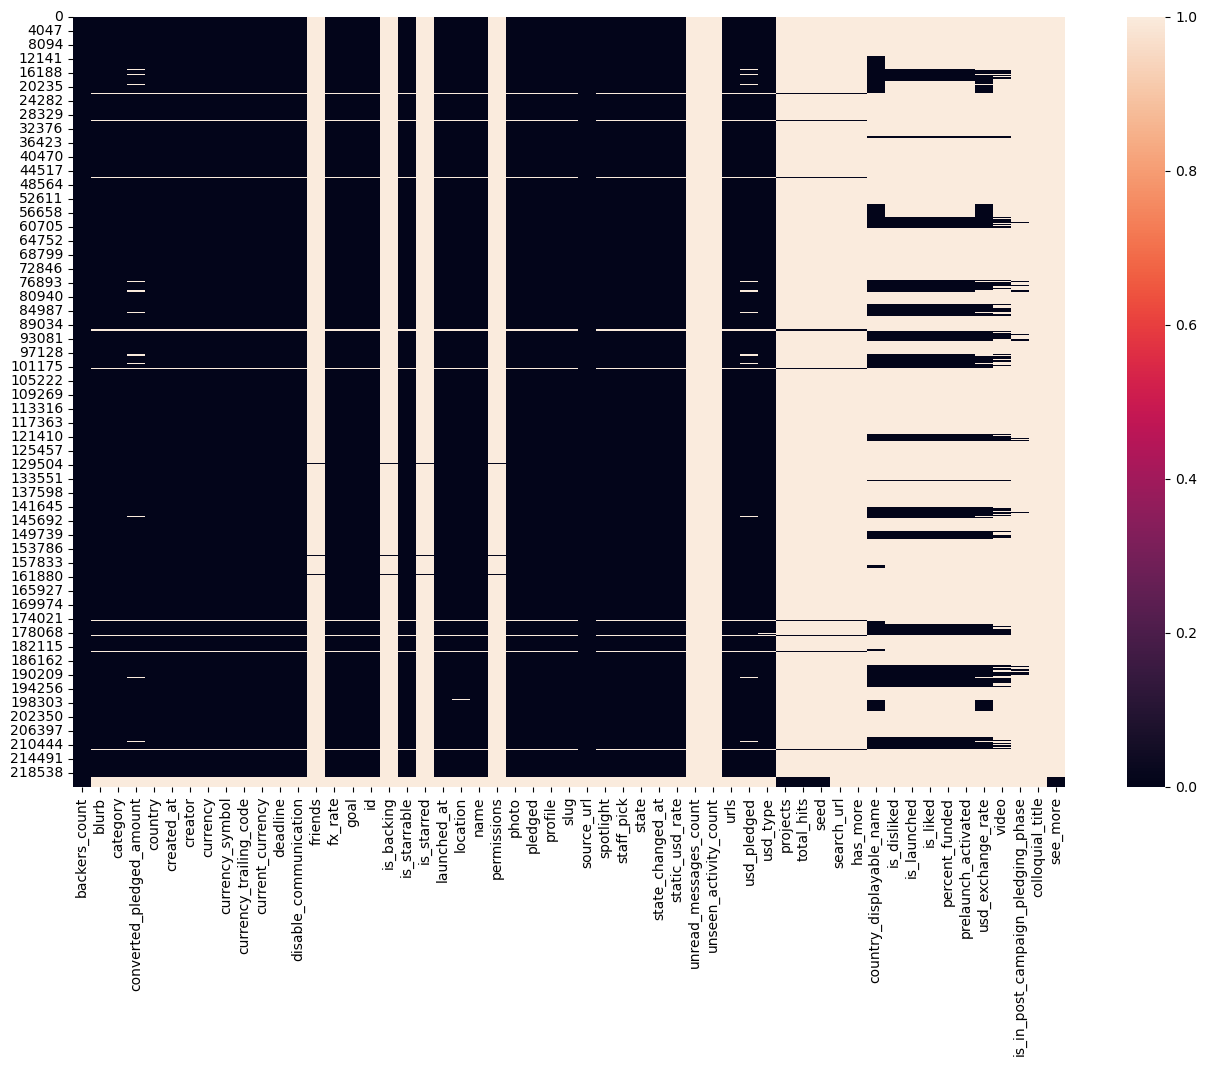

In [3]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("D:/Temp/kickstarter/exports/financement_2.csv")

plt.figure(figsize=(16,10))
sns.heatmap(df.isna())
plt.show()

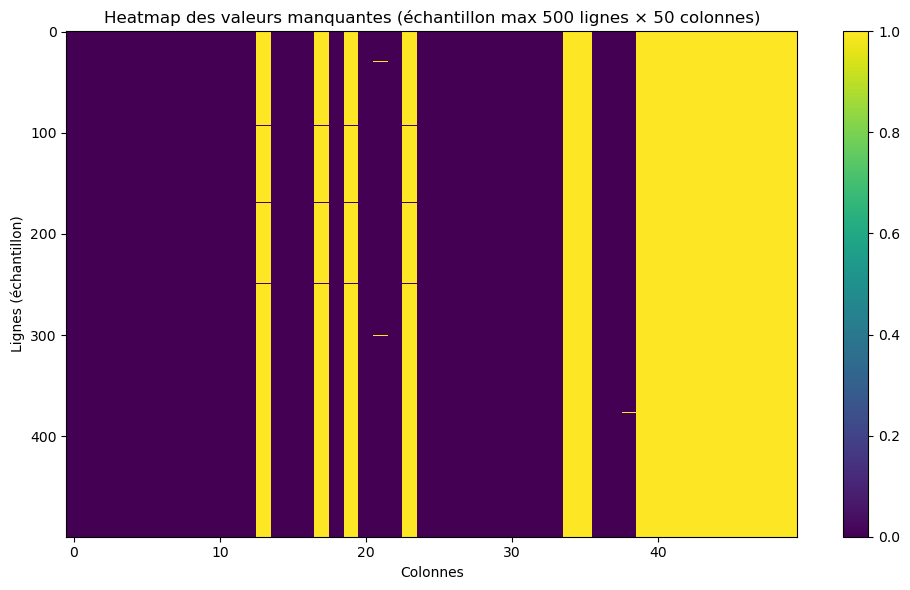

In [4]:
# ============================================================
# Heatmap globale des NaN 
# ============================================================

%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

nan_matrix = df.isna()
max_rows, max_cols = 500, 50
nan_subset = nan_matrix.iloc[:min(len(nan_matrix), max_rows), :min(nan_matrix.shape[1], max_cols)]

plt.figure(figsize=(10, 6))
plt.imshow(nan_subset, aspect='auto', interpolation='nearest')
plt.title("Heatmap des valeurs manquantes (échantillon max 500 lignes × 50 colonnes)")
plt.xlabel("Colonnes")
plt.ylabel("Lignes (échantillon)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [3]:
# ============================================================
# 3) % de valeurs manquantes par colonne
# ============================================================

show_section("3) Pourcentage de valeurs manquantes par colonne")
missing_pct = (df_financement.isna().mean() * 100).round(2).sort_values(ascending=False)
print(missing_pct.to_string())


3) Pourcentage de valeurs manquantes par colonne
converted_pledged_amount    3.65
usd_pledged                 3.65
location                    2.67
usd_type                    2.65
launched_at                 2.58
urls                        2.58
static_usd_rate             2.58
state_changed_at            2.58
staff_pick                  2.58
spotlight                   2.58
slug                        2.58
profile                     2.58
pledged                     2.58
photo                       2.58
name                        2.58
blurb                       2.58
backers_count               2.58
is_starrable                2.58
currency_trailing_code      2.58
category                    2.58
country                     2.58
created_at                  2.58
creator                     2.58
currency                    2.58
id                          2.58
currency_symbol             2.58
current_currency            2.58
deadline                    2.58
disable_communication     

In [6]:
# ============================================================
# 4) Exploration des colonnes
# ============================================================
show_section("4) Exploration des colonnes")
print("Nbre de lignes , Nbre de colonnes:")
df_financement.shape


4) Exploration des colonnes
Nbre de lignes , Nbre de colonnes:


(222562, 38)

In [4]:
df_financement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222562 entries, 0 to 222561
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype              
---  ------                    --------------   -----              
 0   backers_count             216828 non-null  float64            
 1   blurb                     216818 non-null  object             
 2   category                  216828 non-null  object             
 3   converted_pledged_amount  214444 non-null  float64            
 4   country                   216828 non-null  object             
 5   created_at                216828 non-null  datetime64[ns, UTC]
 6   creator                   216828 non-null  object             
 7   currency                  216828 non-null  object             
 8   currency_symbol           216828 non-null  object             
 9   currency_trailing_code    216828 non-null  object             
 10  current_currency          216828 non-null  object             
 11  

### Suppression des colonnes vides à plus de 70%

In [5]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd

from pathlib import Path

# Paramètres

fichier_entree = r"D:/Temp/kickstarter/financement_optimized.parquet"

fichier_sortie = r"D:/Temp/kickstarter/financement_optimized.parquet"

seuil_nan = 0.7

try:

    df = pd.read_parquet(fichier_entree, engine="pyarrow")

except Exception:

    df = pd.read_parquet(fichier_entree, engine="fastparquet")

# Compter les chaînes vides comme NaN  

df = df.replace(r"^\s*$", pd.NA, regex=True)

# Suppression des colonnes avec >= 70% de NaN

taux_nan = df.isna().mean()

colonnes_a_supprimer = taux_nan[taux_nan >= seuil_nan].index.tolist()

df_filtre = df.drop(columns=colonnes_a_supprimer)

# Sauvegarde

Path(fichier_sortie).parent.mkdir(parents=True, exist_ok=True)

try:

    df_filtre.to_parquet(fichier_sortie, engine="pyarrow", index=False)

except Exception:

    df_filtre.to_parquet(fichier_sortie, engine="fastparquet", index=False)

print(f"Colonnes supprimées (>= {int(seuil_nan*100)}% NaN) : {colonnes_a_supprimer}")

print(f"Avant: {df.shape} | Après: {df_filtre.shape}")

print(f"Écrit: {fichier_sortie}")

### Convertir les colonnes évoquant des dates au format Datetime

In [ ]:
import os

import pandas as pd

# ========= Paramètres =========

SOURCE_PATH  = r"D:\Temp\kickstarter\financement.parquet"
OUTPUT_PATH  = r"D:\Temp\Kickstarter\financement_optimized.parquet"
DATE_COLS = ["created_at", "deadline", "launched_at", "state_changed_at"]

# ========= Lecture =========

def read_any(path: str) -> pd.DataFrame:

    ext = os.path.splitext(path)[1].lower()

    if ext in [".parquet", ".pq"]:

        try:

            return pd.read_parquet(path, engine="pyarrow")

        except Exception:

            return pd.read_parquet(path, engine="fastparquet")

    elif ext in [".csv", ".txt"]:

        return pd.read_csv(path, low_memory=False)
    else:

        raise ValueError(f"Extension non gérée: {ext}")

df = read_any(SOURCE_PATH)


# ========= Conversion correcte des dates =========

def fix_unix_seconds(series: pd.Series) -> pd.Series:

    if pd.api.types.is_datetime64_any_dtype(series):

        raw = series.view("int64").where(series.notna())   

       return pd.to_datetime(raw, unit="s", utc=True)
   
    numeric = pd.to_numeric(series, errors="coerce")

    return pd.to_datetime(numeric, unit="s", utc=True)

for col in DATE_COLS:

    if col in df.columns:

        df[col] = fix_unix_seconds(df[col])

print("\nAfter Conversion (aperçu des bornes):")

for col in DATE_COLS:

    if col in df.columns:

        print(f"{col:18s} -> min: {df[col].min()} | max: {df[col].max()}")

print("\nDtypes:")

print(df.dtypes)

# ========= Écriture =========

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
try:
    df.to_parquet(OUTPUT_PATH, engine="pyarrow", index=False)
except Exception:
    df.to_parquet(OUTPUT_PATH, engine="fastparquet", index=False)
print(f"\n✅ Fichier écrit: {OUTPUT_PATH}")

In [5]:
# ============================================================
# 6) Sauvegarde Parquet D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet
# ============================================================

show_section("6) Sauvegarde du Parquet exploré")
target_dir = SAVE_DIR_WIN 
optimized_path = os.path.join(target_dir, OPTIMIZED_FILENAME)
df_financement.to_parquet(optimized_path, engine="pyarrow", compression="zstd", index=False)
print(f"Fichier exploré écrit: {optimized_path}")


6) Sauvegarde du Parquet exploré
Fichier exploré écrit: D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet


## Pré-Visualisation des données du dataframe : 

### Regroupement d'état pour en avoir plus que 2 (successful / failed)

In [ ]:
import os, io, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Paramètres ----------
PARQUET_PATH = r"D:\Temp\Kickstarter\financement_optimized.parquet"
SAVE_DIR_WIN = r"D:\Temp\Kickstarter"
SAVE_DIR_FALLBACK = os.getcwd()
OPTIMIZED_FILENAME = "financement_optimized.parquet"

# ---------- Chargement ----------

try:
    df = pd.read_parquet(PARQUET_PATH, engine="pyarrow")

except Exception:
    df = pd.read_parquet(PARQUET_PATH, engine="fastparquet")

# ============================================================
# Regroupement d'états 
# ============================================================

if "state" in df.columns:

    def collapse_state(val):

        if pd.isna(val):

            return "failed"

        if isinstance(val, str):

            key = val.strip().lower()

            if key in {"", "none", "null", "nan"}:

                return "failed"

        else:

            key = val

        pos = {"successful", "success", "succeeded", "live", "submitted", "started", 1, True}

        neg = {"failed", "fail", "unsuccessful", "canceled", "cancelled", "suspended", 0, False}

        if key in pos:

            return "successful"

        if key in neg:

            return "failed"

        return str(val)

    df["state_grouped"] = df["state"].map(collapse_state)

else:

    print("Colonne 'state' absente : impossible de regrouper.")

# ---------- Helpers ----------

def show_section(title: str):

    print("\n" + "=" * len(title))

    print(title)

    print("=" * len(title))

def try_mkdir(path: str) -> bool:

    try:

        os.makedirs(path, exist_ok=True)

        return True

    except Exception as e:

        print(f"Impossible de créer {path}: {e}")

        return False

# ============================================================
# Features pertinentes
# ============================================================

show_section("Features pertinentes")

state_col_candidates = [

    c for c in df.columns

    if c.lower() in ["state", "project_state", "status"] or "state" in c.lower()

]

state_col = state_col_candidates[0] if state_col_candidates else None

print(f"Colonne d'état utilisée: {state_col}")

if state_col is not None:
    
    target_map = {

        "successful": 1, "success": 1, "succeeded": 1,

        "live": 1, "submitted": 1, "started": 1,

        1: 1, True: 1,

        "failed": 0, "fail": 0, "unsuccessful": 0,

        "canceled": 0, "cancelled": 0,

        "none": 0, "None": 0, "suspended": 0,

        0: 0, False: 0,

    }

    def _map_target(val):

        if isinstance(val, str):

            key = val.strip().lower()

            return target_map.get(key, np.nan)

        return target_map.get(val, np.nan)

    y_mapped = df[state_col].map(_map_target)

    mask = pd.Series(True, index=df.index)

    y = y_mapped

  
    X = df.loc[mask].drop(columns=[state_col], errors="ignore").copy()

   
    for txt in ["blurb", "description", "desc", "name", "title"]:

        if txt in X.columns:

            X[f"{txt}_len"] = X[txt].astype(str).str.len()

  
    def to_dt_df(col):

        if col in df.columns:

            df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)

            return True

        return False

    has_created = (

        to_dt_df('created-at') or

        to_dt_df('created_at') or

        to_dt_df('launched_at') or

        to_dt_df('launched-at')

    )

    has_deadline = (

        to_dt_df('deadline') or

        to_dt_df('deadline_at') or

        to_dt_df('deadline-at')

    )

    if has_created and has_deadline:

        dt_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]

        created_candidates = [c for c in dt_cols if ("created" in c.lower()) or ("launch" in c.lower())]

        deadline_candidates = [c for c in dt_cols if ("deadline" in c.lower()) or ("end" in c.lower())]

        created_c = created_candidates[0] if created_candidates else dt_cols[:1][0]

        deadline_c = deadline_candidates[0] if deadline_candidates else dt_cols[-1]

        df["campaign_duration_days"] = (df[deadline_c] - df[created_c]).dt.total_seconds() / 86400.0

    else:

        df["campaign_duration_days"] = pd.NA

    # Corrélations numériques (Spearman)

    num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

    corr_ser = pd.Series(dtype=float)

    if num_cols:

        corr_ser = (

            X[num_cols]

            .corrwith(y, method="spearman")

            .dropna()

            .sort_values(ascending=False)

        )

        print("\nTop 20 features numériques corrélées au succès (Spearman):")

        if not corr_ser.empty:

            print(corr_ser.head(20).to_string())

        else:

            print("Aucune feature numérique disponible pour la corrélation.")

    else:

        print("Aucune colonne numérique trouvée.")

   

    cat_cols = [c for c in X.columns if X[c].dtype == "object"]

    cat_power = []

    for c in cat_cols:

        tmp = pd.DataFrame({"cat": X[c].astype(str), "y": y})

        rates = tmp.groupby("cat")["y"].mean().dropna()

        if len(rates) >= 2:

            spread = float(rates.max() - rates.min())

            cat_power.append((c, spread, int(rates.count())))

    if cat_power:

        cat_power_df = (

            pd.DataFrame(cat_power, columns=["categorical_feature", "success_rate_range", "n_modalities"])

            .sort_values(["success_rate_range", "n_modalities"], ascending=[False, False])

        )

        print("\nTop 20 catégorielles à fort pouvoir séparateur:")

        print(cat_power_df.head(20).to_string(index=False))

    else:

        print("\nPas assez de colonnes catégorielles pour calculer un pouvoir séparateur.")

else:

    print("Aucune colonne d'état détectée. Étape 8 limitée.")

# ============================================================
# Visualisation – distribution des états de projet
# ============================================================

show_section("Distribution des états de projet (barplot)")

if state_col is not None:

    vc = df["state_grouped"].value_counts(dropna=False)

    plt.figure(figsize=(8, 5))

    plt.bar(vc.index.astype(str), vc.values)

    plt.title("Distribution des états de projet")

    plt.xlabel("État")

    plt.ylabel("Nombre de projets")

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    plt.show()

else:

    print("Pas de colonne d'état détectée.")

# ============================================================
# Vérification et Sauvegarde
# ============================================================

show_section("Sauvegarde du Parquet optimisé")

if "state_grouped" in df.columns:

    df["state"] = df["state_grouped"]        

else:

    print("'state_grouped' manquante avant sauvegarde.")

target_dir = SAVE_DIR_WIN if try_mkdir(SAVE_DIR_WIN) else SAVE_DIR_FALLBACK

optimized_path = os.path.join(target_dir, OPTIMIZED_FILENAME)

try:

    df.to_parquet(optimized_path, engine="pyarrow", compression="zstd", index=False)

except Exception:

    try:

        df.to_parquet(optimized_path, engine="fastparquet", compression="ZSTD", index=False)

    except Exception:

        df.to_parquet(optimized_path, engine="fastparquet", compression="SNAPPY", index=False)

print(f"✅ Fichier optimisé écrit: {optimized_path}")

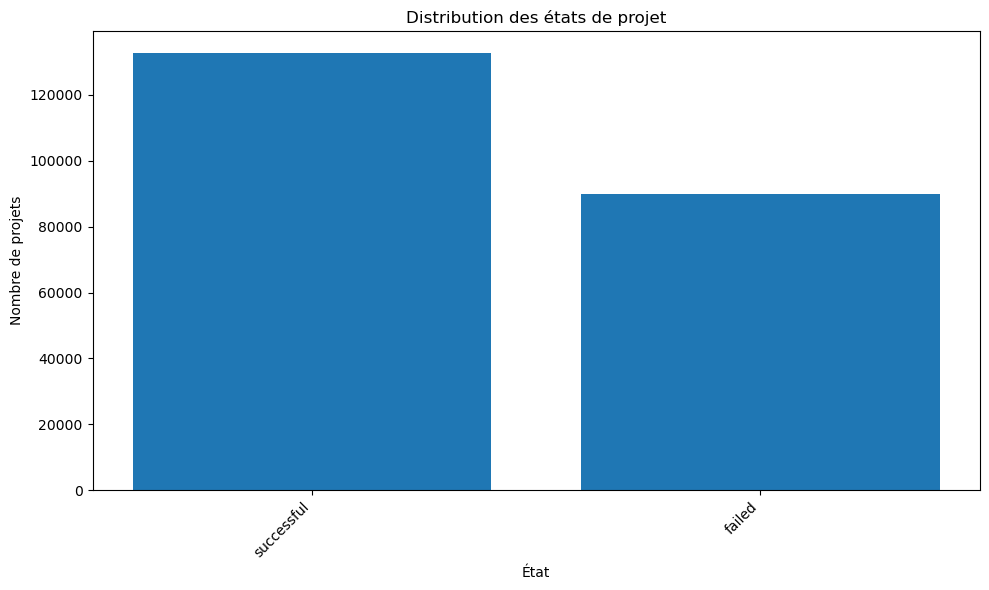

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Paramètres ----------

PARQUET =  r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"

# ---------- Chargement ----------

df_financement = pd.read_parquet(PARQUET)

vc = df_financement["state"].value_counts()

plt.figure(figsize=(10,6))
plt.bar(vc.index.astype(str), vc.values)
plt.title("Distribution des états de projet")
plt.xlabel("État")
plt.ylabel("Nombre de projets")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

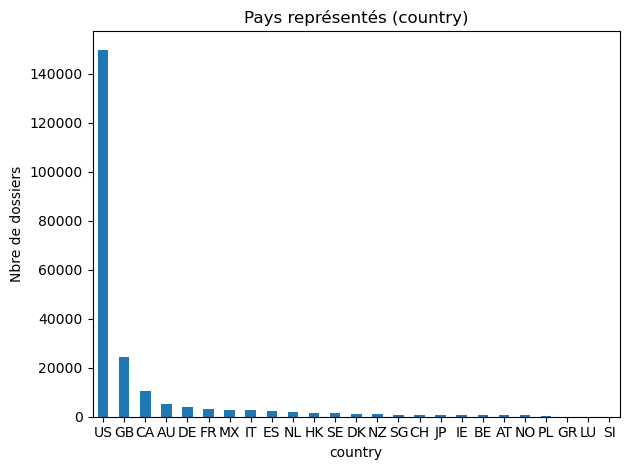

In [7]:
df_financement['country'].value_counts().plot(kind='bar')
plt.title("Pays représentés (country)")
plt.xlabel("country")
plt.ylabel("Nbre de dossiers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Nuage de points Montants demandés vs Montants engagés

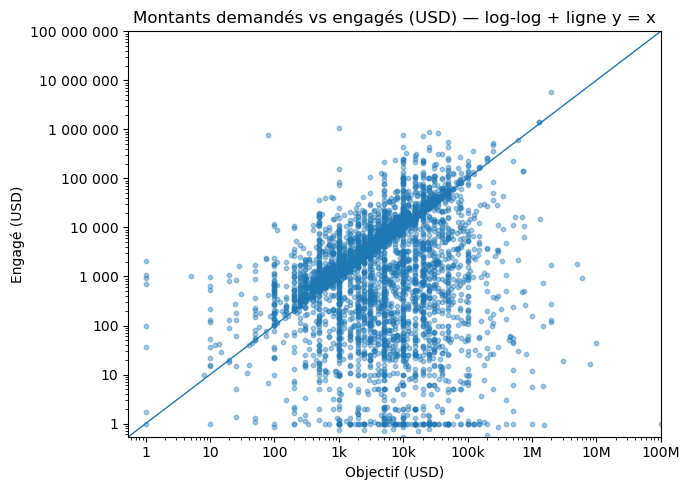

In [9]:
from pathlib import Path

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.ticker as mticker

# ---------- Paramètres ----------

DATA_PATH = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"  

TARGET_POINTS = 50_000        

PER_BATCH_SAMPLE = 5_000      

TITLE = "Montants demandés vs engagés (USD) — log-log + ligne y = x"

# ---------- Helpers ----------

def clean_numeric(df: pd.DataFrame) -> pd.DataFrame:

    """Transforme en numériques + filtre valeurs strictement positives."""

    for c in ("goal", "usd_pledged"):

        if c not in df.columns:

            raise KeyError(f"Colonne manquante: {c}")

        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["goal", "usd_pledged"])

    df = df[(df["goal"] > 0) & (df["usd_pledged"] > 0)]

    return df

def set_log_axes_with_readable_ticks(ax):

    """Axes log, X en k/M/B, Y lisible sans notation scientifique."""

    # -- X: log + k/M/B --

    ax.set_xscale("log")

    ax.xaxis.set_major_locator(mticker.LogLocator(base=10))

    ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))

    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
   
    def fmt_k(x, pos):

        if x <= 0:

            return ""

        for val, suf in [(1e9, "B"), (1e6, "M"), (1e3, "k")]:

            if x >= val:

                v = x / val
               
                if abs(v - round(v)) < 1e-9:

                    return f"{int(round(v))}{suf}"

                return f"{v:.2f}{suf}" if v < 10 else f"{v:.1f}{suf}"

        return f"{int(round(x))}"  # < 1k

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(fmt_k))

    # -- Y: log + milliers lisibles (espaces) --

    ax.set_yscale("log")

    ax.yaxis.set_major_locator(mticker.LogLocator(base=10))

    ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())

    def human_fmt(y, pos):

        if y < 1:

            return f"{y:.3g}".replace(".", ",")

        return f"{int(round(y)):,}".replace(",", " ")

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(human_fmt))

# ---------- Lecture + échantillonnage ----------

path = Path(DATA_PATH)

if not path.exists():

    raise FileNotFoundError(f"Fichier introuvable: {path}")

samples = []

count = 0

if path.suffix.lower() in {".parquet", ".pq"}:

    import pyarrow.parquet as pq

    pf = pq.ParquetFile(str(path))

    for rg in range(pf.metadata.num_row_groups):

        tbl = pf.read_row_group(rg, columns=["goal", "usd_pledged"])

        chunk = clean_numeric(tbl.to_pandas())

        if len(chunk) > PER_BATCH_SAMPLE:

            chunk = chunk.sample(n=PER_BATCH_SAMPLE, random_state=42)

        samples.append(chunk)

        count += len(chunk)

        if count >= TARGET_POINTS:

            break

else:

    # CSV en chunks pour limiter la mémoire

    usecols = lambda c: c in {"goal", "usd_pledged"}

    for chunk in pd.read_csv(str(path), chunksize=100_000, low_memory=False, usecols=usecols):

        chunk = clean_numeric(chunk)

        if len(chunk) > PER_BATCH_SAMPLE:

            chunk = chunk.sample(n=PER_BATCH_SAMPLE, random_state=42)

        samples.append(chunk)

        count += len(chunk)

        if count >= TARGET_POINTS:

            break

df_sc = pd.concat(samples, ignore_index=True) if samples else pd.DataFrame()

if df_sc.empty:

    raise RuntimeError("Aucune donnée exploitable après nettoyage (vérifie les colonnes et les valeurs).")

if len(df_sc) > TARGET_POINTS:

    df_sc = df_sc.sample(n=TARGET_POINTS, random_state=123)

# ---------- Plot ----------

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df_sc["goal"], df_sc["usd_pledged"], alpha=0.4, s=10)

# Ligne de référence y = x (sur l'étendue observée)

mn = float(min(df_sc["goal"].min(), df_sc["usd_pledged"].min()))

mx = float(max(df_sc["goal"].max(), df_sc["usd_pledged"].max()))

mn = max(mn, 1e-6)  # éviter 0 en log

xx = np.logspace(np.log10(mn), np.log10(mx), 200)

ax.plot(xx, xx, linewidth=1)


# Axes 

set_log_axes_with_readable_ticks(ax)

ax.set_xlim(left=mn, right=mx)

ax.set_ylim(bottom=mn, top=mx)


# Titres/labels

ax.set_title(TITLE)

ax.set_xlabel("Objectif (USD)")

ax.set_ylabel("Engagé (USD)")

plt.tight_layout()

plt.show()

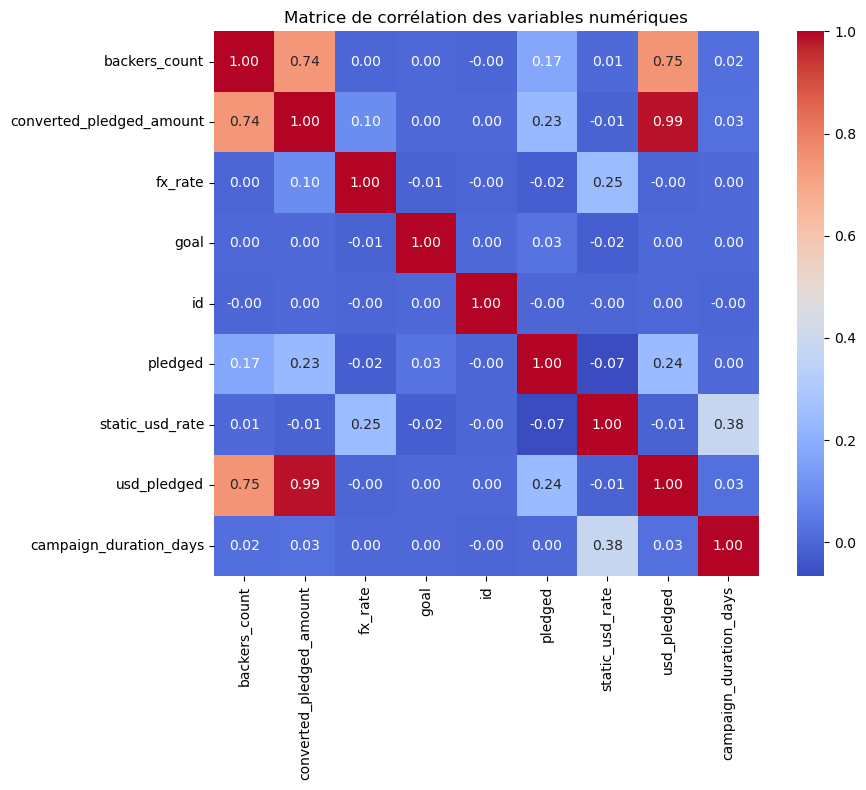

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

num_cols = df_financement.select_dtypes(include=['int64', 'float64'])
corr_matrix = num_cols.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()

In [9]:
df_financement.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,projects,state_grouped,campaign_duration_days
0,1.0,A new technology emerges called augmented real...,"{""id"":29,""name"":""Animation"",""slug"":""film & vid...",1.0,GB,2013-05-11 16:05:28+00:00,"{""id"":1106369748,""name"":""Tirso Hernandez Blane...",GBP,£,False,...,False,failed,2013-07-30 14:58:55+00:00,1.526848,"{""web"":{""project"":""https://www.kickstarter.com...",1.526848,domestic,nan,failed,79.953773
1,23.0,Chasing Stars is a mixed media stop-motion sho...,"{""id"":29,""name"":""Animation"",""slug"":""film & vid...",1496.0,US,2014-04-11 21:32:12+00:00,"{""id"":1082676838,""name"":""Tom Mason"",""is_regist...",USD,$,True,...,False,successful,2014-05-18 16:58:12+00:00,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1496.000000,domestic,nan,successful,36.809722
2,561.0,First Mobile Device Focused on Social Interact...,"{""id"":52,""name"":""Hardware"",""slug"":""technology/...",268192.0,US,2014-04-04 19:22:49+00:00,"{""id"":832648575,""name"":""Alex Yoo of Dos Owls"",...",USD,$,True,...,True,successful,2014-07-08 03:59:01+00:00,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",268192.000000,domestic,nan,successful,94.358461
3,120.0,"""BUBBLE HEADS"" will be the day before story of...","{""id"":29,""name"":""Animation"",""slug"":""film & vid...",7224.0,JP,2017-10-14 06:01:36+00:00,"{""id"":595518883,""name"":""TAKAHIDE HORI"",""is_reg...",JPY,¥,False,...,True,failed,2017-11-25 12:21:42+00:00,0.008777,"{""web"":{""project"":""https://www.kickstarter.com...",7073.531192,domestic,nan,failed,42.263958
4,6.0,Saving the planet drinking water,"{""id"":337,""name"":""Gadgets"",""slug"":""technology/...",332.0,US,2018-12-06 04:32:09+00:00,"{""id"":302531252,""name"":""Alejandro Rodriguez Lo...",USD,$,True,...,False,failed,2019-02-08 22:43:09+00:00,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",332.000000,domestic,nan,failed,64.757639


# Machine Learning

## Préparation de la Variable Cible et Sélection des Features

### Ajout du calcul de longueur (en caractères) de chaque texte de la colonne 'blurb'

In [6]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import os

MAIN_PATH = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"

MAP_PATH  = r"D:\temp\Kickstarter\memoire\dataset\blurb_length_map.parquet"

# Charger uniquement ce qui est nécessaire (économise la RAM)

df_map = pd.read_parquet(MAIN_PATH, columns=["id", "blurb"], engine="pyarrow")

# Clé harmonisée + longueur

df_map["id_key"] = df_map["id"].astype("string")

df_map["blurb_length"] = df_map["blurb"].astype(str).str.len()

# ---- Déduplication  ----

df_map = (

    df_map.groupby("id_key", as_index=False)["blurb_length"]

          .max()

)


# Sauvegarde

os.makedirs(os.path.dirname(MAP_PATH), exist_ok=True)
df_map.to_parquet(MAP_PATH, engine="pyarrow", compression="zstd", index=False)
print(f"✅ Mapping dédupliqué écrit : {MAP_PATH} (rows={len(df_map)})")
print(df_map.head(3))

✅ Mapping dédupliqué écrit : D:\temp\Kickstarter\memoire\dataset\blurb_length_map.parquet (rows=173953)
         id_key  blurb_length
0  1000002330.0           133
1  1000014025.0            77
2   100002171.0           135


### Fusion par clé id

In [ ]:
import os

import pyarrow as pa

import pyarrow.parquet as pq

import pyarrow.dataset as ds

import pandas as pd

MAIN_PATH = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_Optimized_2.parquet"

MAP_PATH  = r"D:\temp\Kickstarter\memoire\dataset\blurb_length_map.parquet"

OUT_PATH  = r"D:\temp\Kickstarter\memoire\dataset\Kickstarter_Campaigns_DataSet_MERGED.parquet"

NEW_COL    = "blurb_length"

KEY_COL    = "id"       

KEY_IN_MAP = "id_key"   

# Charger le mapping 

map_df = pd.read_parquet(MAP_PATH, engine="pyarrow")

assert not map_df[KEY_IN_MAP].duplicated().any(), "Le mapping doit être unique par id_key."

map_s = map_df.set_index(KEY_IN_MAP)[NEW_COL]

del map_df

# Scanner principal par lots

dataset = ds.dataset(MAIN_PATH, format="parquet")

scanner = dataset.scanner(batch_size=100_000)  

writer = None

batch_idx = 0

try:

    for batch in scanner.to_batches():

        batch_idx += 1

        tbl = pa.Table.from_batches([batch])

        cols = tbl.column_names

        if KEY_COL not in cols:

            raise KeyError(f"Colonne clé '{KEY_COL}' absente du dataset principal.")

        # Harmoniser la clé principale en string pour mapper

        key_pd = tbl[KEY_COL].to_pandas().astype("string")

        # Mapping id -> blurb_length

        new_col_pd = key_pd.map(map_s)  

        new_col_pa = pa.array(new_col_pd)

        if NEW_COL in cols:

            tbl = tbl.set_column(cols.index(NEW_COL), NEW_COL, new_col_pa)

        else:

            tbl = tbl.append_column(NEW_COL, new_col_pa)

        if writer is None:

            writer = pq.ParquetWriter(OUT_PATH, tbl.schema, compression="zstd")

        writer.write_table(tbl)

        print(f"✅ Lot {batch_idx:,} écrit ({tbl.num_rows:,} lignes)")

finally:

    if writer is not None:

        writer.close()

print(f"\Fusion terminée. Fichier final : {OUT_PATH}")

## Pipeline Entrainement des modèles (Logistic Regression + Random Forest + Gradient Boosting)

In [2]:
pip install pandas scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import (

    accuracy_score,

    precision_score,

    recall_score,

    f1_score,

    roc_auc_score,

)

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# -------------------------------------------------------------------
# 1. PARAMÈTRES GÉNÉRAUX
# -------------------------------------------------------------------

DATA_DIR = Path(".")

INPUT_FILE = r"D:\temp\Kickstarter\memoire_test\dataset\kickstarter_scored.csv"

OUTPUT_SCORED = r"D:\temp\Kickstarter\memoire_test\dataset\kickstarter_scored.csv"

OUTPUT_FEATURE_IMPORTANCES = r"D:\temp\Kickstarter\memoire_test\dataset\feature_importance_all.csv"

RANDOM_STATE = 42

SAMPLE_SIZE_FOR_TRAIN = 60000   

# -------------------------------------------------------------------
# 2. CHARGEMENT DU DATASET
# -------------------------------------------------------------------

print(f"[INFO] Chargement du fichier : {INPUT_FILE}")

df = pd.read_csv(INPUT_FILE)

print(f"[INFO] Shape initiale : {df.shape}")

# -------------------------------------------------------------------
# 3. NETTOYAGE DES DONNÉES

# -------------------------------------------------------------------


clean = df.copy()

clean = clean[

    (clean["campaign_duration_days"] > 0)

    & (clean["campaign_duration_days"] <= 365)

]

clean = clean[

    (clean["goal"] > 0)

    & (clean["goal"] <= 400000)

]

for col in ["category_name", "goal_bucket", "duration_bucket"]:

    if col in clean.columns:

        clean[col] = clean[col].fillna("Unknown")

print(f"[INFO] Shape après nettoyage : {clean.shape}")

# -------------------------------------------------------------------
# 4. PRÉPARATION DES FEATURES
# -------------------------------------------------------------------

# Variable cible

TARGET_COL = "target"

if TARGET_COL not in clean.columns:

    raise ValueError(f"La colonne cible '{TARGET_COL}' est absente du dataset.")

# Features numériques & catégorielles

feature_cols_num = ["goal", "campaign_duration_days", "blurb_length"]

feature_cols_cat = ["category_name", "country", "currency", "goal_bucket", "duration_bucket"]

for col in feature_cols_num + feature_cols_cat:

    if col not in clean.columns:

        raise ValueError(f"Colonne feature manquante dans les données : {col}")

X = clean[feature_cols_num + feature_cols_cat]

y = clean[TARGET_COL]

if len(clean) > SAMPLE_SIZE_FOR_TRAIN:

    train_sample = clean.sample(n=SAMPLE_SIZE_FOR_TRAIN, random_state=RANDOM_STATE)

    X_train = train_sample[feature_cols_num + feature_cols_cat]

    y_train = train_sample[TARGET_COL]

else:

    X_train = X.copy()

    y_train = y.copy()

X_test = X  

# Préprocesseurs

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(

    transformers=[

        ("num", numeric_transformer, feature_cols_num),

        ("cat", categorical_transformer, feature_cols_cat),

    ]

)

# -------------------------------------------------------------------
# 5. FONCTION GÉNÉRIQUE D’ENTRAÎNEMENT ET D’ÉVALUATION
# -------------------------------------------------------------------

def train_and_evaluate(model, name, X_train, y_train, X_valid, y_valid):

    """
    Entraîne un pipeline (préprocessing + modèle) et retourne le pipeline et les métriques.
    """

    pipe = Pipeline(steps=[

        ("preprocessor", preprocessor),

        ("model", model)

    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_valid)

    y_proba = pipe.predict_proba(X_valid)[:, 1]

    metrics = {

        "model": name,

        "accuracy": accuracy_score(y_valid, y_pred),

        "precision": precision_score(y_valid, y_pred),

        "recall": recall_score(y_valid, y_pred),

        "f1": f1_score(y_valid, y_pred),

        "roc_auc": roc_auc_score(y_valid, y_proba),

    }

    return pipe, metrics

X_tr, X_val, y_tr, y_val = train_test_split(

    X_train, y_train,

    test_size=0.2,

    random_state=RANDOM_STATE,

    stratify=y_train

)

# -------------------------------------------------------------------
# 6. ENTRAÎNEMENT DES MODÈLES
# -------------------------------------------------------------------

print("[INFO] Entraînement Régression Logistique...")

log_reg = LogisticRegression(max_iter=500, class_weight="balanced")

log_pipe, log_metrics = train_and_evaluate(

    log_reg, "Logistic Regression", X_tr, y_tr, X_val, y_val

)

print("[METRICS][LogReg]", log_metrics)

print("[INFO] Entraînement Gradient Boosting...")

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_pipe, gb_metrics = train_and_evaluate(

    gb, "Gradient Boosting", X_tr, y_tr, X_val, y_val

)

print("[METRICS][GradBoost]", gb_metrics)


print("[INFO] Entraînement Random Forest (pour feature importance)...")

rf = RandomForestClassifier(

    n_estimators=150,

    max_depth=12,

    min_samples_split=10,

    min_samples_leaf=5,

    n_jobs=-1,

    random_state=RANDOM_STATE,

    class_weight="balanced_subsample",

)

rf_pipe, rf_metrics = train_and_evaluate(

    rf, "Random Forest", X_tr, y_tr, X_val, y_val

)

print("[METRICS][RandomForest]", rf_metrics)

# -------------------------------------------------------------------
# 7. SCORING COMPLET DU DATASET 
# -------------------------------------------------------------------

print("[INFO] Scoring de toutes les campagnes...")

log_proba = log_pipe.predict_proba(X_test)[:, 1]

log_pred = log_pipe.predict(X_test)

gb_proba = gb_pipe.predict_proba(X_test)[:, 1]

gb_pred = gb_pipe.predict(X_test)

# Ajout des colonnes au dataframe clean

clean_scored = clean.copy()

clean_scored["proba_logreg"] = log_proba

clean_scored["pred_logreg"] = log_pred

clean_scored["proba_gb"] = gb_proba

clean_scored["pred_gb"] = gb_pred

clean_scored["proba_officielle"] = clean_scored["proba_logreg"]

clean_scored["pred_officielle"] = clean_scored["pred_logreg"]

print("[INFO] Exports des scores vers :", OUTPUT_SCORED)

clean_scored.to_csv(OUTPUT_SCORED, index=False)

# -------------------------------------------------------------------
# 8. EXPORT DES IMPORTANCES DE VARIABLES
# -------------------------------------------------------------------

print("[INFO] Calcul des importances de variables...")

# Récupération des noms de variables après encodage

ohe = rf_pipe.named_steps["preprocessor"].named_transformers_["cat"]

num_features = feature_cols_num

cat_features = list(ohe.get_feature_names_out(feature_cols_cat))

all_features = num_features + cat_features

# 8.1. Importances Random Forest

rf_model = rf_pipe.named_steps["model"]

rf_importances = pd.Series(rf_model.feature_importances_, index=all_features)

rf_importances = rf_importances.sort_values(ascending=False)

df_rf_importances = (

    rf_importances

    .reset_index()

    .rename(columns={"index": "feature", 0: "importance"})

)

df_rf_importances["model"] = "RandomForest"

# 8.2. Coefficients Régression Logistique

log_model = log_pipe.named_steps["model"]

coef_series = pd.Series(log_model.coef_[0], index=all_features)

df_log_importances = (

    coef_series

    .reset_index()

    .rename(columns={"index": "feature", 0: "coefficient"})

)

df_log_importances["importance"] = df_log_importances["coefficient"].abs()

df_log_importances["model"] = "LogisticRegression"

# harmonisation des colonnes

df_log_importances = df_log_importances[["feature", "importance", "model"]]

# 8.3. Concat final

df_feat_importances = pd.concat(

    [df_rf_importances[["feature", "importance", "model"]], df_log_importances],

    ignore_index=True

)

print("[INFO] Export des importances vers :", OUTPUT_FEATURE_IMPORTANCES)

df_feat_importances.to_csv(OUTPUT_FEATURE_IMPORTANCES, index=False)

print("[INFO] Terminé ✅")

[INFO] Chargement du fichier : D:\temp\Kickstarter\memoire_test\dataset\kickstarter_scored.csv
[INFO] Shape initiale : (206472, 20)
[INFO] Shape après nettoyage : (206472, 20)
[INFO] Entraînement Régression Logistique...
[METRICS][LogReg] {'model': 'Logistic Regression', 'accuracy': 0.7425, 'precision': 0.8643113159242192, 'recall': 0.6881369751324908, 'f1': 0.7662278710848842, 'roc_auc': 0.84421393548273}
[INFO] Entraînement Gradient Boosting...
[METRICS][GradBoost] {'model': 'Gradient Boosting', 'accuracy': 0.7200833333333333, 'precision': 0.7154243860404997, 'recall': 0.9025682837342031, 'f1': 0.7981734062368563, 'roc_auc': 0.8171303329572915}
[INFO] Entraînement Random Forest (pour feature importance)...
[METRICS][RandomForest] {'model': 'Random Forest', 'accuracy': 0.71375, 'precision': 0.7813306567249785, 'recall': 0.7404538660144041, 'f1': 0.7603432637968325, 'roc_auc': 0.79921564411145}
[INFO] Scoring de toutes les campagnes...
[INFO] Exports des scores vers : D:\temp\Kickstart

## Visualisation des performances

In [8]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# --- PARAMÈTRES ---

output_path = r"D:\temp\Kickstarter\memoire_ML\dataset" 

OPTIMIZED_FILENAME = r"D:\temp\Kickstarter\memoire_ML\dataset\Kickstarter_Campaigns.csv"

# Chemins de sauvegarde des images

ROC_PR_PATH = os.path.join(output_path, 'PHASE5_performance_curves.png')

CONFUSION_PATH = os.path.join(output_path, 'PHASE5_confusion_matrices.png')

IMPORTANCE_PATH = os.path.join(output_path, 'PHASE6_feature_importances.png')

# --- 1. CHARGEMENT ET PRÉPARATION ---

print(f"Chargement des données depuis : {OPTIMIZED_FILENAME}")

df = pd.read_csv(OPTIMIZED_FILENAME, delimiter=';')

# Conversion types

df['state_success'] = pd.to_numeric(df['state_success'], errors='coerce').astype('Int64')

# Features & Target

features = ['log_usd_goal', 'campaign_duration_days', 'country', 'category_name', 'launch_month', 'launch_dayofweek']

target = 'state_success'

df_model = df[features + [target]].dropna()

X = df_model[features]

y = df_model[target]

# Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pipeline

numeric_features = ['log_usd_goal', 'campaign_duration_days']

categorical_features = ['country', 'category_name', 'launch_month', 'launch_dayofweek']

preprocessor = ColumnTransformer(

    transformers=[

        ('num', StandardScaler(), numeric_features),

        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)

    ],

    remainder='passthrough'

)

# Modèles

models = {

    'Régression Logistique': LogisticRegression(solver='liblinear', random_state=48, class_weight='balanced'),

    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=48, class_weight='balanced', max_depth=10),

    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)

}

# Entraînement et Stockage des résultats

trained_models = {}

predictions = {}

probas = {}

print("Entraînement des modèles en cours...")

for name, model in models.items():

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    pipeline.fit(X_train, y_train)

    trained_models[name] = pipeline

    predictions[name] = pipeline.predict(X_test)

    probas[name] = pipeline.predict_proba(X_test)[:, 1]

# --- PHASE 4 : VISUALISATION DES PERFORMANCES ---

# A. Courbes ROC et Precision-Recall

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for name, y_scores in probas.items():

    # ROC

    fpr, tpr, _ = roc_curve(y_test, y_scores)

    roc_auc = auc(fpr, tpr)

    ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    

    # Precision-Recall

    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    ax2.plot(recall, precision, label=name)

# Mise en forme ROC

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)

ax1.set_xlim([0.0, 1.0])

ax1.set_ylim([0.0, 1.05])

ax1.set_xlabel('Taux de Faux Positifs (False Positive Rate)')

ax1.set_ylabel('Taux de Vrais Positifs (True Positive Rate)')

ax1.set_title('Comparaison des Courbes ROC')

ax1.legend(loc="lower right")

ax1.grid(True, alpha=0.3)


# Mise en forme PR

ax2.set_xlabel('Rappel (Recall)')

ax2.set_ylabel('Précision (Precision)')

ax2.set_title('Comparaison Précision-Rappel')

ax2.legend()

ax2.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig(ROC_PR_PATH)

plt.close()

print(f"Graphiques ROC/PR sauvegardés : {ROC_PR_PATH}")


# B. Dashboard Matrices de Confusion

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, y_pred) in enumerate(predictions.items()):

    cm = confusion_matrix(y_test, y_pred)

    # Heatmap avec annotations

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 12})

    

    axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')

    axes[i].set_xlabel('Prédiction Modèle')

    axes[i].set_ylabel('Réalité Terrain')

    axes[i].set_xticklabels(['Échec', 'Succès'])

    axes[i].set_yticklabels(['Échec', 'Succès'])

plt.suptitle('Matrices de Confusion Comparatives', fontsize=16, y=1.05)

plt.tight_layout()

plt.savefig(CONFUSION_PATH)

plt.close()

print(f"Matrices de confusion sauvegardées : {CONFUSION_PATH}")


# --- PHASE 5 : EXTRACTION DE L'IMPORTANCE DES FEATURES ---

feature_importance_data = {}

def get_feature_names(pipeline):

    """Extrait les noms des features après encodage OneHot"""

    preprocessor = pipeline.named_steps['preprocessor']

    ohe = preprocessor.named_transformers_['cat']

    return numeric_features + list(ohe.get_feature_names_out(categorical_features))

# Extraction

for name, pipeline in trained_models.items():

    model = pipeline.named_steps['classifier']

    feature_names = get_feature_names(pipeline)

    
    if name == 'Régression Logistique':

        # Pour la régression, on prend la valeur absolue des coefficients

        importances = model.coef_[0]

        df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})

        df_imp['abs_importance'] = df_imp['importance'].abs()

        df_imp = df_imp.sort_values('abs_importance', ascending=False).head(15)

        feature_importance_data[name] = df_imp

    else:

        # Pour les arbres, on a feature_importances_ directement

        importances = model.feature_importances_

        df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})

        df_imp = df_imp.sort_values('importance', ascending=False).head(15)

        feature_importance_data[name] = df_imp
        

# Visualisation

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for i, (name, df_imp) in enumerate(feature_importance_data.items()):

    sns.barplot(x='importance', y='feature', data=df_imp, ax=axes[i], palette='viridis', hue='feature', legend=False)

    axes[i].set_title(f'Top 15 Facteurs Clés - {name}', fontsize=12)

    axes[i].set_xlabel('Poids / Importance')

    axes[i].set_ylabel('')

plt.tight_layout()

plt.savefig(IMPORTANCE_PATH)

plt.close()

print(f"Analyse d'importance sauvegardée : {IMPORTANCE_PATH}")

print("\n--- ANALYSE COMPLÈTE TERMINÉE ---")

Chargement des données depuis : D:\temp\Kickstarter\memoire_ML\dataset\Kickstarter_Campaigns.csv
Entraînement des modèles en cours...
Graphiques ROC/PR sauvegardés : D:\temp\Kickstarter\memoire_ML\dataset\PHASE5_performance_curves.png
Matrices de confusion sauvegardées : D:\temp\Kickstarter\memoire_ML\dataset\PHASE5_confusion_matrices.png
Analyse d'importance sauvegardée : D:\temp\Kickstarter\memoire_ML\dataset\PHASE6_feature_importances.png

--- ANALYSE COMPLÈTE TERMINÉE ---


In [5]:
import pandas as pd
df = pd.read_csv(r"D:\temp\Kickstarter\memoire\dataset\ML_Artifacts\X_features_step1.csv")


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222562 entries, 0 to 222561
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   goal                    216828 non-null  float64
 1   campaign_duration_days  216828 non-null  float64
 2   blurb_length            216828 non-null  float64
 3   category                216828 non-null  object 
 4   country                 216828 non-null  object 
 5   currency                216828 non-null  object 
 6   launched_at             214444 non-null  object 
 7   deadline                216828 non-null  object 
dtypes: float64(3), object(5)
memory usage: 13.6+ MB


In [14]:
print(df.columns.tolist())

['goal', 'campaign_duration_days', 'blurb_length', 'category', 'country', 'currency', 'launched_at', 'deadline']


In [7]:
df.head()

,goal,campaign_duration_days,blurb_length,category,country,currency,launched_at,deadline
0,15000.0,79.953773,132.0,"{""id"":29,""name"":""Animation"",""slug"":""film & vid...",GB,GBP,2013-06-29 14:58:54+00:00,2013-07-30 14:58:54+00:00
1,1000.0,36.809722,124.0,"{""id"":29,""name"":""Animation"",""slug"":""film & vid...",US,USD,2014-04-18 16:58:12+00:00,2014-05-18 16:58:12+00:00
2,250000.0,94.358461,117.0,"{""id"":52,""name"":""Hardware"",""slug"":""technology/...",US,USD,2014-05-28 11:54:18+00:00,2014-07-08 03:59:00+00:00
3,5000000.0,42.263958,90.0,"{""id"":29,""name"":""Animation"",""slug"":""film & vid...",JP,JPY,2017-10-26 11:21:42+00:00,2017-11-25 12:21:42+00:00
4,5000.0,64.757639,32.0,"{""id"":337,""name"":""Gadgets"",""slug"":""technology/...",US,USD,2018-12-10 22:43:09+00:00,2019-02-08 22:43:09+00:00


In [8]:
import pandas as pd
df = pd.read_csv(r"D:\temp\Kickstarter\memoire\dataset\ML_Artifacts\Y_target_step1.csv")

In [9]:
df.head()

,target
0,0
1,1
2,1
3,0
4,0


# Visualisation - Préparatoin pour Power Bi

In [31]:
# ============================================
#     ÉTAPE — Export pour Power BI
#     (Préparation d'un CSV complet)
# ============================================

import os

import json

import numpy as np

import pandas as pd

import joblib

# ----------------- CONFIGURATION -----------------

OUT_DIR = r"D:\temp\Kickstarter\memoire\dataset\ML_Artifacts"

# Fichiers d'entrée

X_FEATURES_CSV = os.path.join(OUT_DIR, "X_features_step1.csv")

Y_TARGET_CSV   = os.path.join(OUT_DIR, "Y_target_step1.csv")

X_TRAIN_PROC   = os.path.join(OUT_DIR, "X_train_processed.csv")

LR_MODEL_PKL   = os.path.join(OUT_DIR, "lr_model.pkl")

RF_MODEL_PKL   = os.path.join(OUT_DIR, "rf_model.pkl")

# Fichier de sortie pour Power BI

CSV_OUT_BI     = os.path.join(OUT_DIR, "PowerBI_predictions_full.csv")

# -------------------------------------------------

print("\n--- ÉTAPE 8 : Préparation d'un CSV pour Power BI ---")

# 1) Charger les données brutes (Étape 1)

X_raw = pd.read_csv(X_FEATURES_CSV, low_memory=False)

Y_all = pd.read_csv(Y_TARGET_CSV).squeeze()

print("Shapes brutes :")

print("  X_raw :", X_raw.shape)

print("  Y_all :", Y_all.shape)

# Sanity check

if len(X_raw) != len(Y_all):

    raise ValueError("X_features_step1 et Y_target_step1 n'ont pas la même longueur !")

# ----------------------------------------------------------
# 2) Reprise du feature engineering 
# ----------------------------------------------------------

def extract_cat_name(s):

    if pd.isna(s):

        return np.nan

    if not isinstance(s, str):

        return str(s)

    try:

        d = json.loads(s)

        if "name" in d:

            return d["name"]

        if "slug" in d:

            return d["slug"]

        return str(d)

    except Exception:

        return s

def extract_parent_name(s):

    if pd.isna(s):

        return np.nan

    if not isinstance(s, str):

        return np.nan

    try:

        d = json.loads(s)

        if "parent_name" in d:

            return d["parent_name"]

        return np.nan

    except Exception:

        return np.nan

print("\nReconstruction des features (comme Étape 2)...")

X_feat = X_raw.copy()

X_feat["category_name"]   = X_feat["category"].apply(extract_cat_name)

X_feat["category_parent"] = X_feat["category"].apply(extract_parent_name)

X_feat = X_feat.drop(columns=["category"])

X_feat["launched_at"] = pd.to_datetime(X_feat["launched_at"], errors="coerce")

X_feat["deadline"]    = pd.to_datetime(X_feat["deadline"],    errors="coerce")

X_feat["launch_month"]       = X_feat["launched_at"].dt.month

X_feat["launch_day_of_week"] = X_feat["launched_at"].dt.dayofweek

X_feat["goal_log"] = np.log1p(X_feat["goal"])

X_feat["campaign_duration_scaled"] = (

    (X_feat["campaign_duration_days"] - X_feat["campaign_duration_days"].mean())

    / X_feat["campaign_duration_days"].std()

)

X_feat["blurb_length_scaled"] = (

    (X_feat["blurb_length"] - X_feat["blurb_length"].mean())

    / X_feat["blurb_length"].std()

)

# On enlève les colonnes brutes utilisées

X_feat = X_feat.drop(columns=[

    "launched_at", "deadline",

    "goal", "campaign_duration_days", "blurb_length"

])

print("Colonnes après feature engineering :", len(X_feat.columns))

# ----------------------------------------------------------
# 3) Encodage catégoriel (get_dummies) 
# ----------------------------------------------------------

CATEGORICAL_COLS = [

    "category_name",

    "category_parent",

    "country",

    "currency",

    "launch_month",

    "launch_day_of_week",

]

X_all_encoded = pd.get_dummies(

    X_feat,

    columns=CATEGORICAL_COLS,

    drop_first=True,

    dtype=float

)

print("Shape après dummies (global) :", X_all_encoded.shape)

# ----------------------------------------------------------
# 4) Alignement des colonnes avec le modèle entraîné
# ----------------------------------------------------------

X_train_ref = pd.read_csv(X_TRAIN_PROC)    

train_cols = X_train_ref.columns.tolist()


X_model_input = X_all_encoded.reindex(columns=train_cols, fill_value=0.0)

print("Shape finale X_model_input :", X_model_input.shape)


num_cols = X_model_input.select_dtypes(include=["float64", "float32", "int64", "int32"]).columns

X_model_input[num_cols] = X_model_input[num_cols].fillna(X_model_input[num_cols].median())

# ----------------------------------------------------------
# 5) Charger les modèles & générer les prédictions
# ----------------------------------------------------------

print("\nChargement des modèles LR & RF...")

lr_model = joblib.load(LR_MODEL_PKL)

rf_model = joblib.load(RF_MODEL_PKL)

print("Prédictions en cours...")

proba_lr = lr_model.predict_proba(X_model_input)[:, 1]

pred_lr  = lr_model.predict(X_model_input)

proba_rf = rf_model.predict_proba(X_model_input)[:, 1]

pred_rf  = rf_model.predict(X_model_input)

# ----------------------------------------------------------
# 6) Construction du DataFrame final pour Power BI
# ----------------------------------------------------------

print("Construction du DataFrame final pour Power BI...")

cols_meta = [

    "goal", "campaign_duration_days", "blurb_length",

    "category", "country", "currency",

]


df_bi = X_raw[cols_meta].copy()

df_bi["target"]  = Y_all.values

df_bi["pred_lr"] = pred_lr

df_bi["proba_lr"] = proba_lr

df_bi["pred_rf"] = pred_rf

df_bi["proba_rf"] = proba_rf

print("\nAperçu des colonnes du CSV Power BI :")

print(df_bi.columns.tolist())

print(df_bi.head(5))

# ----------------------------------------------------------
# 7) Sauvegarde CSV
# ----------------------------------------------------------

df_bi.to_csv(CSV_OUT_BI, index=False, encoding="utf-8")
print(f"\n--- ÉTAPE 8 terminée. Fichier Power BI sauvegardé : {CSV_OUT_BI} ---")


--- ÉTAPE 8 : Préparation d'un CSV pour Power BI ---
Shapes brutes :
  X_raw : (222562, 8)
  Y_all : (222562,)

Reconstruction des features (comme Étape 2)...
Colonnes après feature engineering : 9
Shape après dummies (global) : (222562, 232)
Shape finale X_model_input : (222562, 232)

Chargement des modèles LR & RF...
Prédictions en cours...
Construction du DataFrame final pour Power BI...

Aperçu des colonnes du CSV Power BI :
['goal', 'campaign_duration_days', 'blurb_length', 'category', 'country', 'currency', 'target', 'pred_lr', 'proba_lr', 'pred_rf', 'proba_rf']
        goal  campaign_duration_days  blurb_length  \
0    15000.0               79.953773         132.0   
1     1000.0               36.809722         124.0   
2   250000.0               94.358461         117.0   
3  5000000.0               42.263958          90.0   
4     5000.0               64.757639          32.0   

                                            category country currency  target  \
0  {"id":29,"name"